In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from models.supervised_VAE import SupervisedVariationalAutoEncoder
import numpy as np

# Direct input
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 20,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params)
plt.style.use('seaborn-dark-palette')

device = "cpu"


/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


In [6]:
# Dataloader code adapted from https://gist.github.com/xmfbit/b27cdbff68870418bdb8cefa86a2d558
import os
import torchvision.datasets as dset
import torchvision.transforms as transforms

root = "./data"
if not os.path.exists(root):
    os.mkdir(root)

n_labeled_data = 1000

np.random.seed(42)

# We want to prespecify the indices that we assume are hidden
# so we return the indices along the data
class IndexedMNIST(dset.MNIST):
    def __init__(self, n_labeled_data=100, **kwargs):
        super().__init__(**kwargs)

        # Be nice and mark the labeled data equally across classes
        assert n_labeled_data % 10 == 0, (
            "Number of labeled data needs to be divisible from 10" "to ensure class balance"
        )
        n_items_per_class = n_labeled_data // 10

        supervised_idxes = []
        unsupervised_idxes = []

        for cls in range(10):
            permuted_cls_idxes = np.random.permutation(np.where(self.targets.numpy() == cls)[0])
            supervised_idxes.append(permuted_cls_idxes[:n_items_per_class])
            unsupervised_idxes.append(permuted_cls_idxes[n_items_per_class:])

        self.supervised_idxes = np.concatenate(supervised_idxes)
        self.unsupervised_idxes = np.concatenate(unsupervised_idxes)

        self.supervised_idxes_set = set(self.supervised_idxes.tolist())

        assert (
            n_labeled_data == 0 or np.unique(self.targets.numpy()[self.supervised_idxes]).size == 10
        ), "Not all classes are included in the supervised set"

        self.class_identity = torch.eye(10)
        self.dummy_unlabeled_class = torch.zeros(10)

    def __getitem__(self, index):
        img, hidden_ground_truth = super().__getitem__(index)
        target_flat = hidden_ground_truth

        if index in self.supervised_idxes_set:
            target = self.class_identity[target_flat]  # return one-hot encoded label
        else:
            target = self.dummy_unlabeled_class
            target_flat = -1
        return img, target, target_flat, hidden_ground_truth


balanced_dataloader = True

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1.0,))])
train_set = IndexedMNIST(n_labeled_data=n_labeled_data, root=root, train=True, transform=trans, download=True)

batch_size = 100

if balanced_dataloader:
    # Inspired by https://stackoverflow.com/questions/66065272/customizing-the-batch-with-specific-elements
    class Sampler:
        def __init__(self, batch_size, supervised_idxes, unsupervised_idxes):
            self.batch_size = batch_size
            self.supervised_idxes = supervised_idxes
            self.unsupervised_idxes = unsupervised_idxes

        def __iter__(self):
            np.random.shuffle(train_set.supervised_idxes)
            np.random.shuffle(train_set.unsupervised_idxes)

            n_supervised = train_set.supervised_idxes.shape[0]
            n_unsupervised = train_set.unsupervised_idxes.shape[0]
            n_total = n_unsupervised + n_supervised

            ratio_sup_total = n_supervised / n_total
            ratio_unsup_total = 1.0 - ratio_sup_total

            n_unsup_samples_batch = int(self.batch_size * ratio_unsup_total)
            n_sup_samples_batch = self.batch_size - n_unsup_samples_batch

            batches = []
            for i in range(n_total // self.batch_size):
                batch = np.concatenate(
                    (
                        train_set.supervised_idxes[
                            (i * n_sup_samples_batch) % n_supervised : ((i + 1) * n_sup_samples_batch) % n_supervised
                        ],  # circular indexing in case
                        # we run out of room. We assume it's fine because supervised samples underrepresented anyway
                        train_set.unsupervised_idxes[i * n_unsup_samples_batch : (i + 1) * n_unsup_samples_batch],
                    )
                )
                batches.append(batch)
            return iter(batches)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_sampler=Sampler(
            batch_size=batch_size,
            supervised_idxes=train_set.supervised_idxes,
            unsupervised_idxes=train_set.unsupervised_idxes,
        ),
    )
else:
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

test_set = IndexedMNIST(n_labeled_data=1000, root=root, train=False, transform=trans, download=True)


test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [7]:
supervised_vae = (
    SupervisedVariationalAutoEncoder(
        28 * 28,
        [500, 500],
        bottleneck_size=100,
        n_sample_z=1,
        kl_term_weight=1.0,
        loss="cont_bern",
        output_activation=nn.Sigmoid(),
        n_classes=10,
        use_unsupervised_data=True,
    )
    .to(device)
    .train()
)


In [8]:
def train_model(model, epochs=10):
    print("Starting")
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    loss_step = []
    class_acc = []

    batch = next(iter(train_loader))
    batch_input = batch[0].view(-1, 28*28).to(device)

    print(f"Len of the batch: {batch_input.shape[0]}")

    for epoch in (pbar:= tqdm(range(epochs))):
        for step, batch in enumerate(train_loader):

            input_data, label_data, label_data_flat, hidden_ground_truth = batch
            B = input_data.shape[0] 

            train_info = model.train_step((input_data.squeeze().view(B, -1), label_data, label_data_flat))

            class_acc.append(torch.count_nonzero( (torch.argmax(train_info["classification_probs"], dim=-1) 
                                            - hidden_ground_truth) == 0) / B)
            train_loss = train_info["train_loss"]
            loss = train_loss

            # output_full = model(batch_input)
            # output_decoded = output_full["mu_x"]

            if not isinstance(loss, float):
                optimizer.zero_grad()
                loss.backward()

                optimizer.step()

                loss = loss.cpu()

                loss_step.append(loss.detach().numpy())
                pbar.set_description(f"Loss: {np.mean(loss_step[-50:]):.2f} "
                                    f"Classification accuracy: {np.mean(class_acc[-50:]):.2f}")

In [9]:
train_model(supervised_vae)


Starting
Len of the batch: 100


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
@torch.no_grad()
def do_inference(model, data):
    output = []
    inputs = []
    labels = []
    mu_zs = []
    mu_xs = []
    for batch in data:
        batch_input = batch[0].view(-1, 28 * 28).to(device)
        full_output = model(batch_input, batch[1])
        labels.append(batch[3].numpy().squeeze())
        output.append(full_output)
        inputs.append(batch[0].numpy().squeeze())
        mu_zs.append(full_output["mu_z"].cpu().detach().numpy().squeeze())
        mu_xs.append(full_output["mu_x"].cpu().detach().numpy().squeeze().reshape((-1, 28, 28)))
    return {
        "full_output": output,
        "inputs": np.concatenate(inputs, axis=0),
        "labels": np.concatenate(labels, axis=0),
        "mu_zs": np.concatenate(mu_zs, axis=0),
        "mu_xs": np.concatenate(mu_xs, axis=0),
    }


In [11]:
train_outputs_vae = do_inference(supervised_vae, test_loader)


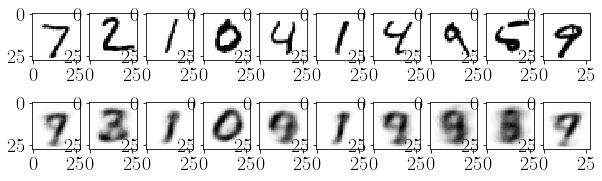

In [12]:
"""
Look at (original,reconstructed) pairs
"""
fig, axes = plt.subplots(2, 10, figsize=(10, 3))

for i in range(10):
    axes[0, i].imshow(train_outputs_vae["inputs"][i], cmap="binary")
for i in range(10):
    axes[1, i].imshow(train_outputs_vae["mu_xs"][i], cmap="binary")


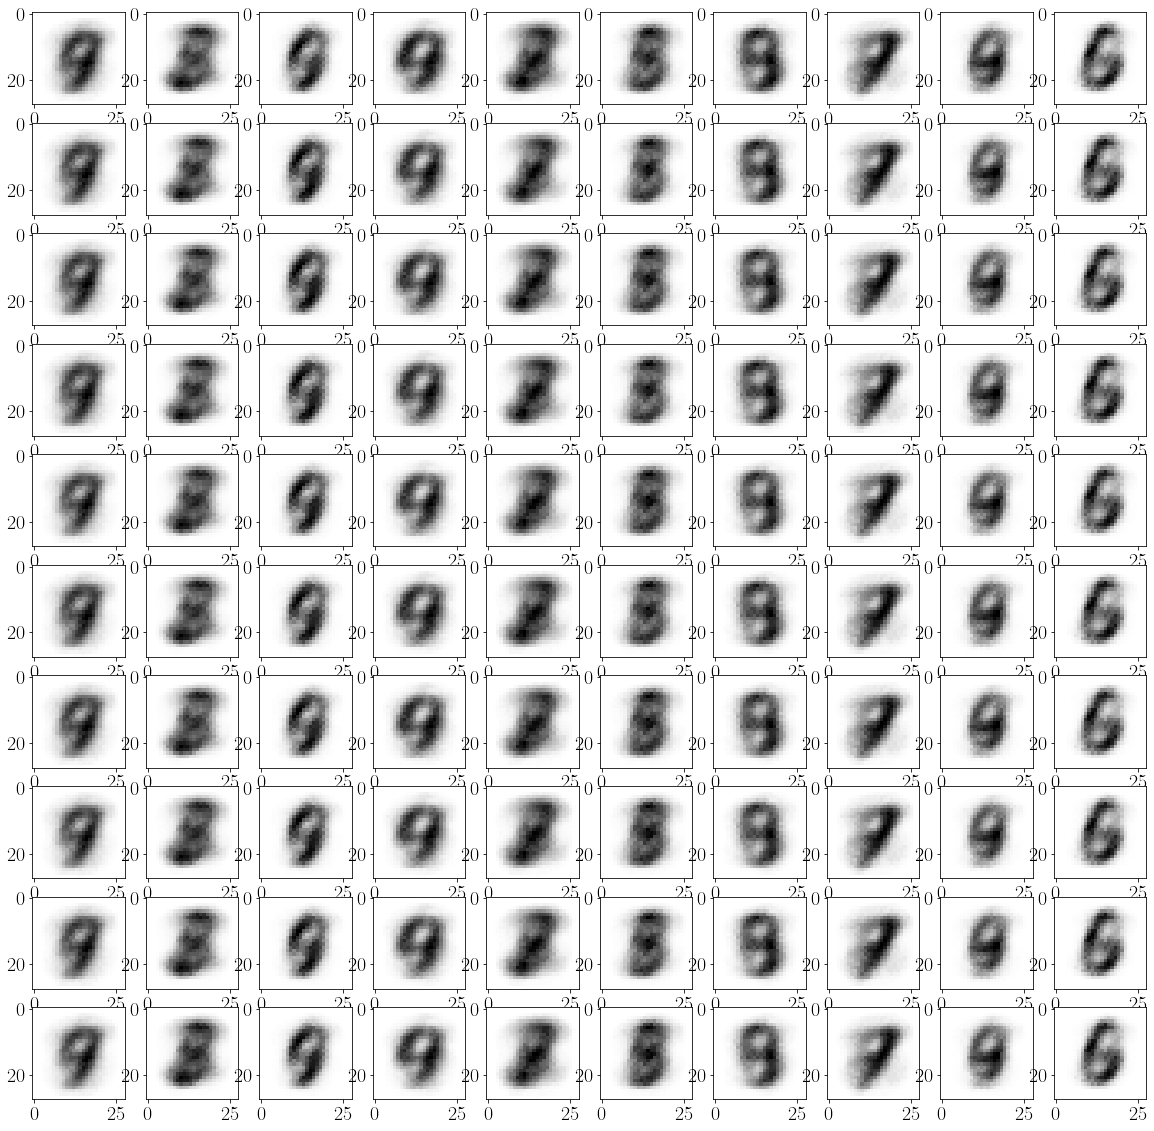

In [13]:
"""
Sample z from N(0, I) and show the reconstructions for all digits
"""

fig, axes = plt.subplots(10, 10, figsize=(20, 20))

zs = []
device_old = device
device = "cpu"
supervised_vae = supervised_vae.to("cpu").train(False)

zs = torch.from_numpy(np.random.randn(10, 100)).float()
for i in range(10):
    for j in range(zs.shape[0]):
        z_in, digit_in = zs[j][None, :], torch.tensor(np.eye(10)[i])[None, :].float()

        # z_in = z = torch.from_numpy(np.random.randn(1, 2)).float()
        decoded_vae = supervised_vae.decode(z_in, digit_in)[0].squeeze().detach().numpy().reshape((28, 28))

        axes[i, j].imshow(decoded_vae, cmap="binary")

device = device_old
supervised_vae = supervised_vae.to(device)


In [ ]:
"""
Display the digit manifold in 2D space. 

To achieve this, note that the prior is an independent Gaussian, so 
it's sufficient to take 1D Gaussian, take interval points from uniform
regions that correspond to the Gaussian CDF and reconstruct at those points 
"""

interval_size = 20

from scipy.stats import norm

pnts_z_1d = norm.ppf(np.linspace(1.0 / interval_size, 1.0 - 1.0 / interval_size, interval_size))

crossed = np.array([[(x, y) for y in pnts_z_1d] for x in pnts_z_1d])


In [575]:
for digit in range(10):
    fig, axes = plt.subplots(20, 20, figsize=(10, 10))

    one_hot = torch.from_numpy(np.eye(10)[digit][None, :]).float()

    for i in range(20):
        for j in range(20):
            z = torch.from_numpy(crossed[i, j][None, :]).float()

            decoded_vae = supervised_vae.decode(z, one_hot)[0].squeeze().detach().numpy().reshape((28, 28))

            axes[i, j].imshow(decoded_vae, cmap="binary")
            axes[i, j].axis("off")
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    plt.savefig(f"plots/m2_mnist_n_{digit}_manifold_supervised.png", dpi=300)
    plt.show()


RuntimeError: shape '[1, 100]' is invalid for input of size 2

Error in callback <function flush_figures at 0x7f0e5a1919d0> (for post_execute):


KeyboardInterrupt: 